In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mido import MidiFile, tick2second
from pretty_midi import PrettyMIDI
import pickle
import os
import os.path
import multiprocessing

### Generating bootleg score

In [3]:
def showImage(X, sz = (6,6)):
    plt.figure(figsize = sz)
    plt.imshow(X, cmap = 'gray', origin = 'lower')

In [4]:
def getNoteEvents(midifile, quant = 10):
    ### Given a midi file, return a list of (t_tick, t_sec, notes) tuples for simultaneous note events
    
    # get note onset info
    mid = MidiFile(midifile)
    noteEvents = []
    for i, track in enumerate(mid.tracks):
        t = 0 
        for msg in track:
            t += msg.time # ticks since last event
            if msg.type == 'note_on' and msg.velocity > 0:
                noteEvents.append((t, msg.note))
    noteEvents = sorted(noteEvents) # merge note events from all tracks, sort by time
    noteTimes = PrettyMIDI(midifile).get_onsets() # in sec
    noteOnsets = [(t_ticks, t_sec, note) for ((t_ticks, note), t_sec) in zip(noteEvents, noteTimes)]
    
    # collapse simultaneous notes
    d = {}
    ticks_quant = [n[0]//quant for n in noteOnsets] # quantized time units (ticks)
    for n, t_quant in zip(noteOnsets, ticks_quant):
        if t_quant not in d:
            d[t_quant] = {}
            d[t_quant]['ticks'] = []
            d[t_quant]['secs'] = []
            d[t_quant]['notes'] = []
        d[t_quant]['ticks'].append(n[0])
        d[t_quant]['secs'].append(n[1])
        d[t_quant]['notes'].append(n[2])
        
    result = [(d[key]['ticks'][0], d[key]['secs'][0], d[key]['notes']) for key in sorted(d.keys())]
    
    return result, d # return d for debugging

In [5]:
def generateBootlegScore(noteEvents, repeatNotes = 1, filler = 1):
    rh_dim = 34 # E3 to C8 (inclusive)
    lh_dim = 28 # A1 to G4 (inclusive)
    rh = [] # list of arrays of size rh_dim
    lh = [] # list of arrays of size lh_dim
    numNotes = [] # number of simultaneous notes
    times = [] # list of (tsec, ttick) tuples indicating the time in ticks and seconds
    mapR, mapL = getNoteheadPlacementMapping() # maps midi numbers to locations on right and left hand staves
    for i, (ttick, tsec, notes) in enumerate(noteEvents):
        
        # insert empty filler columns between note events
        if i > 0:
            for j in range(filler):
                rh.append(np.zeros((rh_dim,1)))
                lh.append(np.zeros((lh_dim,1)))
                numNotes.append(0)
            # get corresponding times using linear interpolation
            interp_ticks = np.interp(np.arange(1, filler+1), [0, filler+1], [noteEvents[i-1][0], ttick])
            interp_secs = np.interp(np.arange(1, filler+1), [0, filler+1], [noteEvents[i-1][1], tsec])
            for tup in zip(interp_secs, interp_ticks):
                times.append((tup[0], tup[1]))

        # insert note events columns
        rhvec = np.zeros((rh_dim, 1))
        lhvec = np.zeros((lh_dim, 1))
        for midinum in notes:
            rhvec += getNoteheadPlacement(midinum, mapR, rh_dim)
            lhvec += getNoteheadPlacement(midinum, mapL, lh_dim)
        for j in range(repeatNotes):
            rh.append(rhvec)
            lh.append(lhvec)
            numNotes.append(len(notes))
            times.append((tsec, ttick))
    rh = np.clip(np.squeeze(np.array(rh)).T, 0, 1) # clip in case e.g. E and F played simultaneously
    lh = np.clip(np.squeeze(np.array(lh)).T, 0, 1) 
    both = np.vstack((lh, rh))
    staffLinesRH = [7,9,11,13,15]
    staffLinesLH = [13,15,17,19,21]
    staffLinesBoth = [13,15,17,19,21,35,37,39,41,43]
    return both, times, numNotes, staffLinesBoth, (rh, staffLinesRH), (lh, staffLinesLH)

In [6]:
def getNoteheadPlacementMapping():
    r = getNoteheadPlacementMappingRH()
    l = getNoteheadPlacementMappingLH()
    #r, l = addOctaveChanges(r, l) # uncomment to include octave markings
    #r, l = addClefChanges(r, l) # uncomment to include different clefs
    return r, l

In [7]:
def getNoteheadPlacementMappingLH():
    d = {}
    # e.g. d[23] = [1,2] indicates that B0 could appear as a B or a C-flat, which means
    # that the notehead could be located at positions 1 or 2
    d[21] = [0] # A0 (position 0)
    d[22] = [0,1]
    d[23] = [1,2] # B0
    d[24] = [1,2] # C1
    d[25] = [2,3]
    d[26] = [3] # D1
    d[27] = [3,4]
    d[28] = [4,5] # E1
    d[29] = [4,5] # F1
    d[30] = [5,6]
    d[31] = [6] # G1
    d[32] = [6,7] 
    d[33] = [7] # A1
    d[34] = [7,8]
    d[35] = [8,9] # B1
    d[36] = [8,9] # C2
    d[37] = [9,10] 
    d[38] = [10] # D2
    d[39] = [10,11] 
    d[40] = [11,12] # E2
    d[41] = [11,12] # F2
    d[42] = [12,13] 
    d[43] = [13] # G2
    d[44] = [13,14] 
    d[45] = [14] # A2
    d[46] = [14,15] 
    d[47] = [15,16] # B2
    d[48] = [15,16] # C3
    d[49] = [16,17] 
    d[50] = [17] # D3
    d[51] = [17,18] 
    d[52] = [18,19] # E3
    d[53] = [18,19] # F3
    d[54] = [19,20] 
    d[55] = [20] # G3
    d[56] = [20,21] 
    d[57] = [21] # A3
    d[58] = [21,22] 
    d[59] = [22,23] # B3
    d[60] = [22,23] # C4
    d[61] = [23,24] 
    d[62] = [24] # D4
    d[63] = [24,25] 
    d[64] = [25,26] # E4
    d[65] = [25,26] # F4
    d[66] = [26,27] 
    d[67] = [27] # G4
    return d

In [8]:
def getNoteheadPlacementMappingRH():
    d = {}
    # e.g. d[52] = [0,1] indicates that E3 could appear as an E or an F-flat, which means
    # that the notehead could be located at positions 0 or 1
    d[52] = [0,1] # E3 (position 0)
    d[53] = [0,1] # F3
    d[54] = [1,2]
    d[55] = [2] # G3
    d[56] = [2,3]
    d[57] = [3] # A3
    d[58] = [3,4]
    d[59] = [4,5] # B3
    d[60] = [4,5] # C4
    d[61] = [5,6]
    d[62] = [6] # D4
    d[63] = [6,7]
    d[64] = [7,8] # E4
    d[65] = [7,8] # F4
    d[66] = [8,9]
    d[67] = [9] # G4
    d[68] = [9,10]
    d[69] = [10] # A4
    d[70] = [10,11]
    d[71] = [11,12] # B4
    d[72] = [11,12] # C5
    d[73] = [12,13]
    d[74] = [13] # D5
    d[75] = [13,14]
    d[76] = [14,15] # E5
    d[77] = [14,15] # F5
    d[78] = [15,16]
    d[79] = [16] # G5
    d[80] = [16,17]
    d[81] = [17] # A5
    d[82] = [17,18] 
    d[83] = [18,19] # B5
    d[84] = [18,19] # C6
    d[85] = [19,20]
    d[86] = [20] # D6
    d[87] = [20,21]
    d[88] = [21,22] # E6
    d[89] = [21,22] # F6
    d[90] = [22,23]
    d[91] = [23] # G6
    d[92] = [23,24] 
    d[93] = [24] # A6
    d[94] = [24,25]
    d[95] = [25,26] # B6
    d[96] = [25,26] # C7
    d[97] = [26,27]
    d[98] = [27] # D7
    d[99] = [27,28] 
    d[100] = [28,29] # E7
    d[101] = [28,29] # F7
    d[102] = [29,30]
    d[103] = [30] # G7
    d[104] = [30,31]    
    d[105] = [31] # A7
    d[106] = [31,32]
    d[107] = [32,33] # B7
    d[108] = [32,33] # C8
    return d

In [9]:
def addOctaveChanges(r, l):
    
    # add octaves in treble clef for G5 and above
    for midinum in r:
        if midinum >= 79:
            toAdd = []
            for staffpos in r[midinum]:
                toAdd.append(staffpos - 7) # 7 staff positions = 1 octave
            r[midinum].extend(toAdd)
    
    # add octaves in bass clef for F2 and below
    for midinum in l:
        if midinum <= 41:
            toAdd = []
            for staffpos in l[midinum]:
                toAdd.append(staffpos + 7)
            l[midinum].extend(toAdd)
    
    return r, l

In [10]:
def addClefChanges(r, l):
    
    # clef change in rh
    for midinum in range(36, 65):  # C2 to E4
        if midinum not in r:
            r[midinum] = []
        for staffpos in l[midinum]:
            r[midinum].append(staffpos - 6) # shift between L and R staves (e.g. middle staff line is pos 11 in rh, pos 17 in lh)
            
    # clef change in lh
    for midinum in range(57, 85): # A3 to C6
        if midinum not in l:
            l[midinum] = []
        for staffpos in r[midinum]:
            l[midinum].append(staffpos + 6)
            
    return r, l

In [11]:
def getNoteheadPlacement(midinum, midi2loc, dim):
    r = np.zeros((dim, 1))
    if midinum in midi2loc:
        for idx in midi2loc[midinum]:
            r[idx,0] = 1
    return r

In [12]:
def visualizeBootlegScore(bs, lines):
    showImage(1 - bs, (10,10))
    for l in range(1, bs.shape[0], 2):
        plt.axhline(l, c = 'b')
    for l in lines:
        plt.axhline(l, c = 'r')

In [13]:
midifile = 'data/midi/p1.mid'
repeatNotes = 2
filler = 1

/home/tjtsai/anaconda2/envs/SheetMidiRetrieval/lib/python3.6/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


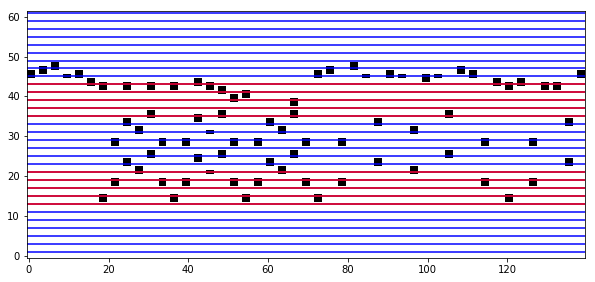

In [14]:
note_events, _ = getNoteEvents(midifile)
bscore, times, num_notes, stafflines, _, _ = generateBootlegScore(note_events, repeatNotes, filler)
visualizeBootlegScore(bscore[:,0:140], stafflines)

In [15]:
def compressBootlegScore(bscore):
    assert bscore.shape[0] <= 64
    compressed = np.zeros(bscore.shape[1], dtype=np.uint64)
    binary2bit = np.power(2,np.arange(bscore.shape[0])).astype(np.uint64).reshape((1,-1))
    compressed = np.squeeze(np.matmul(binary2bit, bscore)).astype(np.uint64)
    return compressed

In [16]:
c = compressBootlegScore(bscore)

### begin experiment

In [17]:
# def computeAggregatedBscore(midiseq):
    
#     # load search region model
#     model_file = 'experiments/search4/searchRegions.pkl'
#     with open(model_file, 'rb') as f:
#         rowRanges = pickle.load(f)
    
#     midi_len = len(midiseq)
#     query_len = len(rowRanges) # max allowable chunk size
#     R = np.zeros((query_len, midi_len), dtype = np.uint64)
#     for j, (offset_start, offset_end) in enumerate(rowRanges):
#         for offset in range(offset_start, offset_end):
#             chunk = midiseq[offset:]
#             chunkLen = len(chunk)
#             R[j,0:chunkLen] = np.bitwise_or(R[j,0:chunkLen], chunk)
#     return R

### Process midi files

In [17]:
def processMidiFile(midifile, outfile):
    
    ### system parameters ###
    timeQuantFactor = 10
    bootlegRepeatNotes = 1
    bootlegFiller = 0
    #########################
    
    print("Processing {}".format(midifile))
    note_events, _ = getNoteEvents(midifile, timeQuantFactor)
    bscore, times, num_notes, stafflines, _, _ = generateBootlegScore(note_events, bootlegRepeatNotes, bootlegFiller)
    compressed = compressBootlegScore(bscore)
    #aggregated = computeAggregatedBscore(compressed)
    
    # save to file
    d = {'bscore': bscore, 'times': times, 'num_notes': num_notes, 'stafflines': stafflines, 
         'note_events': note_events, 'compressed': compressed}
    with open(outfile, 'wb') as f:
        pickle.dump(d, f)

In [18]:
def processAllMidiFiles(filelist, outdir):
    if not os.path.isdir(outdir):
        os.makedirs(outdir)
    pkl_files = []
    with open(filelist, 'r') as f:
        for curfile in f:
            curfile = curfile.rstrip()
            basename = os.path.splitext(os.path.basename(curfile))[0]
            outfile = "{}/{}.pkl".format(outdir, basename)
            processMidiFile(curfile, outfile)
            pkl_files.append(outfile)
    return pkl_files

First process the midi files in the train/test set

In [19]:
filelist_query = 'cfg_files/midi.train.list' # list of query midi files to process
basedir = 'experiments/search5'
outdir = '{}/db/single'.format(basedir) # where to save bootleg scores
query_pkl_files = processAllMidiFiles(filelist_query, outdir)

Processing data/midi/p1.mid
Processing data/midi/p5.mid
Processing data/midi/p11.mid
Processing data/midi/p15.mid
Processing data/midi/p21.mid
Processing data/midi/p25.mid
Processing data/midi/p31.mid
Processing data/midi/p35.mid
Processing data/midi/p41.mid
Processing data/midi/p45.mid
Processing data/midi/p51.mid
Processing data/midi/p55.mid
Processing data/midi/p61.mid
Processing data/midi/p65.mid
Processing data/midi/p71.mid
Processing data/midi/p75.mid
Processing data/midi/p81.mid
Processing data/midi/p85.mid
Processing data/midi/p91.mid
Processing data/midi/p95.mid


Now process the midi files in the Lakh Midi Dataset.  Since this list is very long, we will parallelize it.

In [20]:
# process all queries
filelist_lakh = 'cfg_files/lakh.pruned.list' # list of lakh midi files to process
basedir = 'experiments/search5'
outdir = '{}/db/single'.format(basedir) # where to save bootleg scores

# prep output directory
if not os.path.isdir(outdir):
    os.makedirs(outdir)

# number of cores to use
n_cores = 16 #multiprocessing.cpu_count()

# prep inputs for parallelization
inputs = []
with open(filelist_lakh, 'r') as f:
    for line in f:
        midfile = line.rstrip()
        basename = os.path.splitext(os.path.basename(midfile))[0]
        outfile = '{}/{}.pkl'.format(outdir, basename)
        if os.path.exists(outfile): # skip files that have already been generated
            continue
        inputs.append((midfile, outfile))

In [ ]:
# process queries in parallel
pool = multiprocessing.Pool(processes=n_cores)
outputs = list(pool.starmap(processMidiFile, inputs))

### Construct Database

In [21]:
def constructDB(filelist, outfile):
    # filelist: list of .pkl files to include in the database
    # outfile: .pkl file that will contain entire database
    
    # generate db
    db = {}
    for pkl_file in filelist:
        with open(pkl_file, 'rb') as f:
            d = pickle.load(f)
            pieceid = os.path.splitext(os.path.basename(pkl_file))[0] # e.g. 'p7'
            db[pieceid] = d
    
    # save to file
    with open(outfile, 'wb') as f:
        pickle.dump(db, f)

In [22]:
def constructDB_compressed(filelist, outfile):
    # filelist: list of .pkl files to include in the database
    # outfile: .pkl file that will contain entire database
    
    # construct db
    data = [] # all compressed bootleg scores concatenated end-to-end
    num_notes = [] # note counts from bootleg scores concatenated end-to-end
    boundaries = [0] # starting index for each database item + final end index
    pieces = [] # list of piece ids
    for pkl_file in filelist:
        with open(pkl_file, 'rb') as f:
            d = pickle.load(f)
            pieceid = os.path.splitext(os.path.basename(pkl_file))[0] # e.g. 'p7'
            cbs = d['compressed']
            data.extend(d['compressed'])
            num_notes.extend(d['num_notes'])
            boundaries.append(len(data))
            pieces.append(pieceid)
    
    # save to file
    db = {}
    db['data'] = np.array(data, dtype=np.uint64)
    db['num_notes'] = np.array(num_notes, dtype=np.uint8)
    db['boundaries'] = boundaries
    db['pieces'] = pieces
    with open(outfile, 'wb') as f:
        pickle.dump(db, f)

In [23]:
def constructDBList(query_filelist, filler_filelist, N = None):
    r = []
    if N is None: # use entire filler list
        r.extend(query_filelist)
        r.extend(filler_filelist)
    else:
        r.extend(query_filelist)
        numToAdd = N - len(query_filelist)
        assert numToAdd > 0
        r.extend(filler_filelist[0:numToAdd])
    return r

In [24]:
def getFillerPklFilelist(midi_filelist, pkl_dir):
    pkl_filelist = []
    with open(midi_filelist, 'r') as f:
        for line in f:
            midi_fullpath = line.rstrip()
            basename = os.path.splitext(os.path.basename(midi_fullpath))[0]
            pkl_file = '{}/{}.pkl'.format(pkl_dir, basename)
            assert os.path.exists(pkl_file)
            pkl_filelist.append(pkl_file)
    return pkl_filelist

In [28]:
db_file = '{}/db/db_2k.pkl'.format(basedir)
filler_pkl_files = getFillerPklFilelist(filelist_lakh, outdir)
db_items = constructDBList(query_pkl_files, filler_pkl_files, N = 2000)
constructDB_compressed(db_items, db_file)